In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
pip install praat-parselmouth

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 60.1 MB/s eta 0:00:0000:010:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
import librosa
import numpy as np
import pandas as pd
import os
import csv
import tqdm
from scipy.io import wavfile 

In [3]:
import parselmouth

In [13]:

labels=[]
paths=[]

directory_path='/kaggle/input/svd-voice-sample/SVD NEW'
for i in os.listdir(directory_path):
  # print(i)
  for k in os.listdir('/kaggle/input/svd-voice-sample/SVD NEW/'+i):
    paths.append('/kaggle/input/svd-voice-sample/SVD NEW/'+i+'/'+k)
    if i=='Pathology SS':
      labels.append(0)
    else:
      labels.append(1)

In [14]:
df1 = pd.DataFrame({'path': paths, 'label': labels})
df1

,path,label
0,/kaggle/input/svd-voice-sample/SVD NEW/Patholo...,0
1,/kaggle/input/svd-voice-sample/SVD NEW/Patholo...,0
2,/kaggle/input/svd-voice-sample/SVD NEW/Patholo...,0
3,/kaggle/input/svd-voice-sample/SVD NEW/Patholo...,0
4,/kaggle/input/svd-voice-sample/SVD NEW/Patholo...,0
...,...,...
2323,/kaggle/input/svd-voice-sample/SVD NEW/Healthy...,1
2324,/kaggle/input/svd-voice-sample/SVD NEW/Healthy...,1
2325,/kaggle/input/svd-voice-sample/SVD NEW/Healthy...,1
2326,/kaggle/input/svd-voice-sample/SVD NEW/Healthy...,1


In [18]:
def get_voice_data():
    n_list = []
    j_list = []
    s_list = []
    h_list = []
    label_list=[]

    # # for wav_file in wav_files:
    for i in range(len(labels)): # tqdm shows the progress bar
        wav_file=df1['path'][i]
        l=df1['label'][i]
        sound = parselmouth.Sound(wav_file) # sound object from wav file
        pitch = sound.to_pitch()
        pulses = parselmouth.praat.call([sound, pitch], "To PointProcess (cc)")

       # jitter
        jitter_local = parselmouth.praat.call(pulses, "Get jitter (local)", 0.0, 0.0, 0.0001, 0.02, 1.3) * 100
      
        # shimmer
        shimmer_local = parselmouth.praat.call([sound, pulses], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)

        # HNR
        harmonicity = parselmouth.praat.call(sound, "To Harmonicity (cc)", 0.01, 75, 0.1, 1.0)
        hnr = parselmouth.praat.call(harmonicity, "Get mean", 0, 0)
        
        j_list.append(jitter_local)
        s_list.append(shimmer_local)
        h_list.append(hnr)
        label_list.append(l)
        

      
    df = pd.DataFrame({"Label":pd.Series(label_list),
                          
                          "Jitter":pd.Series(j_list),
                          "Shimmer":pd.Series(s_list),
                           "HNR": pd.Series(h_list),
                          })

    # new_df = pd.concat([df, mfcc_df], axis=1, sort=False)     
    return df

In [19]:
df_feature=get_voice_data()

In [24]:
df_feature=  df_feature.dropna()

In [25]:
label = df_feature['Label']
data = df_feature.drop(['Label'], axis=1)

In [26]:
data

,Jitter,Shimmer,HNR
0,0.256901,0.029378,25.078635
1,1.233304,0.076703,14.974482
2,0.657349,0.045507,19.026361
3,0.273097,0.015061,24.894573
4,0.338691,0.042577,19.627645
...,...,...,...
2323,1.417868,0.043428,16.704698
2324,0.280439,0.026463,24.692906
2325,0.285498,0.036184,24.541058
2326,0.302295,0.015506,29.046057


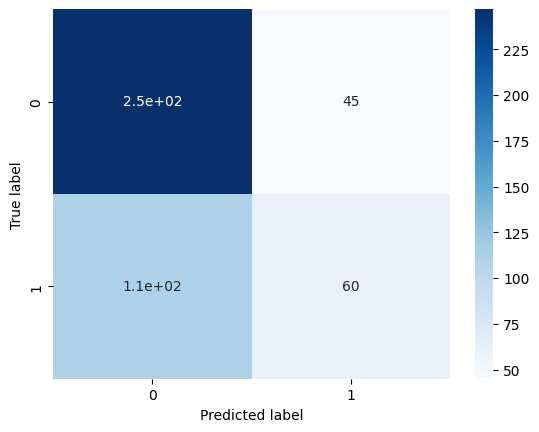

In [27]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
# Load data


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42)

# Fit a logistic regression model
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

# Make predictions on test data
y_pred = lr_model.predict(X_test)

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using Seaborn heatmap
sns.heatmap(conf_matrix, annot=True, cmap="Blues")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()


In [ ]:
accuracy = lr_model.score(X_test, y_test)
print(accuracy)